In [1]:
# Reload utils module to get latest changes
from importlib import reload
import utils
reload(utils)

# Import everything we need from utils
from utils import *

# Configure pandas display
pd.set_option("display.max_columns", 200)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data path
DATA_PATH = "/dsi/fetaya-lab/noam_diamant/projects/intuit/data.csv"


# Show the data information

In [2]:
# Load and basic cleanup
raw = pd.read_csv(DATA_PATH)
print("Shape: ", raw.shape)
print("# transactions are: ", raw.shape[0])
print("# attributes are: ", raw.shape[1], "\n\n")

Shape:  (1000000, 6)
# transactions are:  1000000
# attributes are:  6 




In [3]:
raw.head(10)

,user_id,description,category,amount,date,gender
0,2415848187644231731,-,Babysitter & Daycare,-105.70,2016-12-02,M
1,2415848187644231731,-,Transfer,-712.31,2016-12-02,M
2,7621821633626091160,-,Finance Charge,-2.02,2016-12-02,M
3,2215014179620581716,-,Parking,-5.20,2016-12-02,F
4,906409546992525081,CVS,Pharmacy,-14.13,2016-12-02,M
5,8450426553679461645,-,Hotel,-263.53,2016-12-02,F
6,7108016686999469858,-,Music,-5.23,2016-12-02,M
7,1650846412181785257,-,Paycheck,1604.75,2016-12-02,F
8,1650846412181785257,McDonald's,Fast Food,-5.12,2016-12-02,F
9,3894302339387823463,-,Taxes,-143.48,2016-12-02,F


### Some users IDs are repeating! 

If you train directly on transaction-level rows:

Each transaction becomes an input, but the label (gender) is duplicated for all of a user’s transactions.

You’ll have hundreds of highly correlated rows per user.

During train/test split, some transactions of a user may go to training, others to test and the model will effectively see the user’s data during training. We will inflated accuracy (data leakage).

The model would really be predicting “what kind of transaction is this”, not the gender of the person.

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   user_id      1000000 non-null  int64  
 1   description  1000000 non-null  object 
 2   category     1000000 non-null  object 
 3   amount       1000000 non-null  float64
 4   date         1000000 non-null  object 
 5   gender       1000000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 45.8+ MB


### No need to fill nulls...
### Also, according to the assignment description, null is not possible


# now lets look for exact duplicates

In [5]:
# Show an example of a duplicate row
print("\nExample of a duplicate transaction:")
duplicate = raw[raw.duplicated(keep=False)].sort_values(['user_id', 'description', 'category', 'amount', 'date', 'gender']).head(2)
print("\nRow numbers:", duplicate.index.tolist())
print(duplicate)

print("\n--------------------------------\n")

df = raw.copy()
# Deduplicate rows
before = len(df)
df = df.drop_duplicates()
print("Raw data shape: ", raw.shape)
print("Deduplicated data shape: ", df.shape)
print(f"Dropped duplicates: {before - len(df)}")




Example of a duplicate transaction:

Row numbers: [152996, 174364]
                  user_id description   category  amount        date gender
152996  19306846752703627           -  Financial  -66.71  2016-11-25      F
174364  19306846752703627           -  Financial  -66.71  2016-11-25      F

--------------------------------

Raw data shape:  (1000000, 6)
Deduplicated data shape:  (956759, 6)
Dropped duplicates: 43241


### Let's see how many users we have

In [6]:
# count the users
labels = df[['user_id', 'gender']].drop_duplicates(subset='user_id')
print("number of users is: ", labels.shape[0])
print(labels.head(3))

number of users is:  1200
               user_id gender
0  2415848187644231731      M
2  7621821633626091160      M
3  2215014179620581716      F


# distrubtion of the data by users

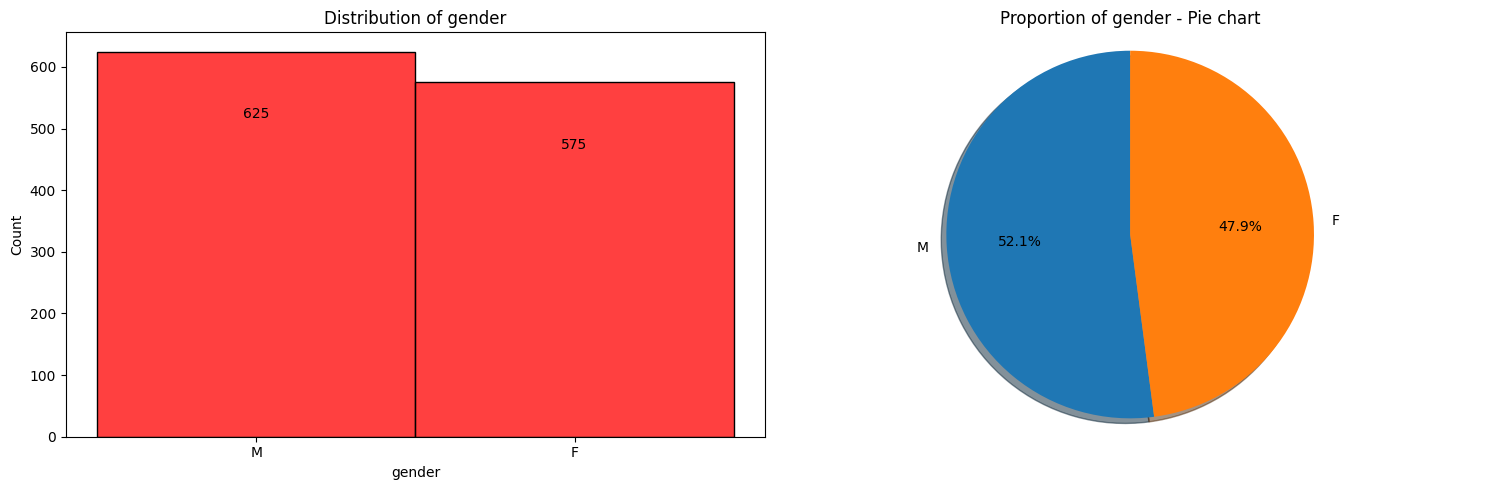

In [7]:
# Create a figure with one row and two columns
target =pd.DataFrame(labels['gender']) 

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the displot on the first subplot
ax = sns.histplot(target, x='gender', color='red', discrete=True, ax=axes[0])
axes[0].set_title('Distribution of gender')  # add title for the first subplot
axes[0].set_xticks([0, 1])  # Set x-ticks to show only 0 and 1

# Add count labels on top of each bar
for i, p in enumerate(ax.patches):
    count = int(p.get_height())
    ax.annotate(str(count), 
                xy=(p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(0, -50),  # 50 points vertical offset
                textcoords='offset points',
                ha='center',
                va='bottom')

# Plot the pie chart on the second subplot
axes[1].pie(target['gender'].value_counts(), labels=target['gender'].unique(), autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[1].set_title('Proportion of gender - Pie chart')  # add title for the second subplot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### The data is quite balanced, yay!

### Map raw categories to our main category mapping


In [ ]:
import xgboost as xgb

# Create XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=RANDOM_STATE
)

# Add to models dictionary
models['XGBoost'] = xgb_clf


In [8]:
# Map raw categories to our main category mapping
df['category'] = raw['category'].map(utils.category_mapping)

df.head()

,user_id,description,category,amount,date,gender
0,2415848187644231731,-,Kids,-105.70,2016-12-02,M
1,2415848187644231731,-,Transfer,-712.31,2016-12-02,M
2,7621821633626091160,-,Fees & Charges,-2.02,2016-12-02,M
3,2215014179620581716,-,Auto & Transport,-5.20,2016-12-02,F
4,906409546992525081,CVS,Health & Fitness,-14.13,2016-12-02,M


In [9]:
_df = df.copy()
_df['date'] = pd.to_datetime(_df['date'])
_df['dayofweek'] = _df['date'].dt.dayofweek.astype(int)

Money Flow analysis:


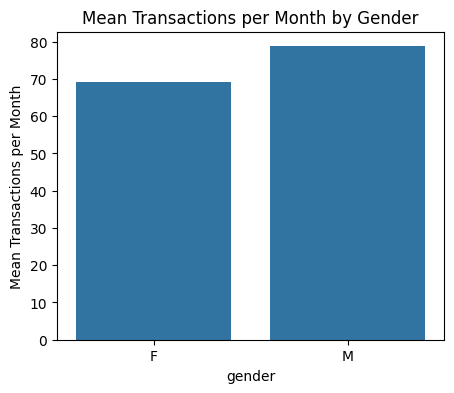

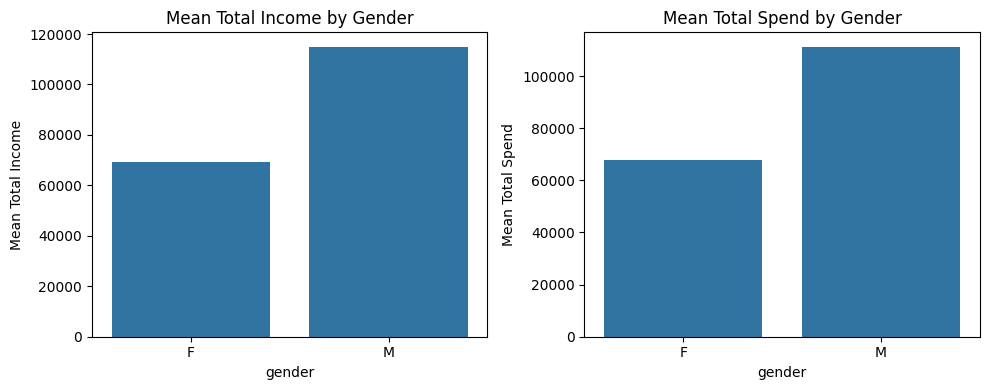

Temporal analysis:


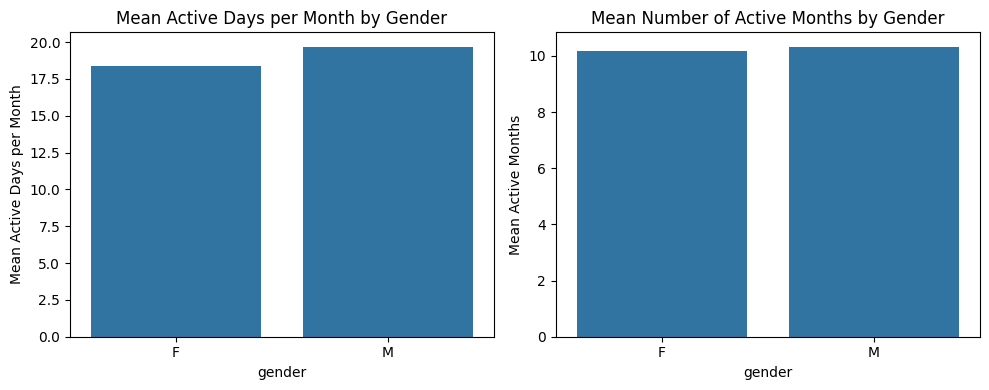

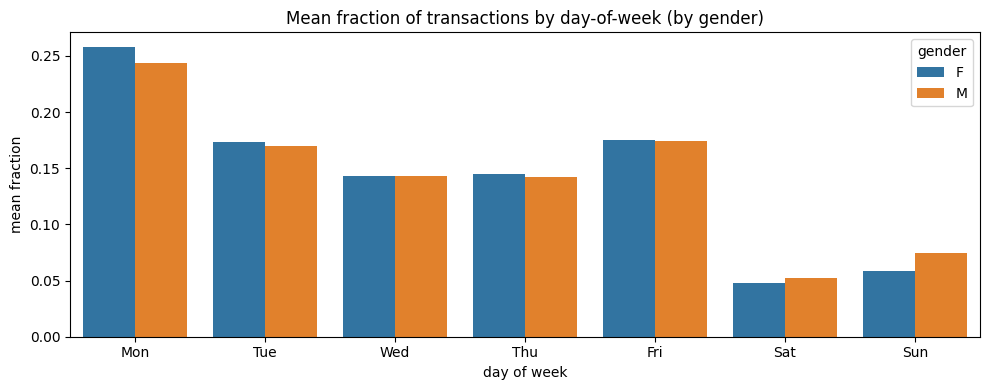

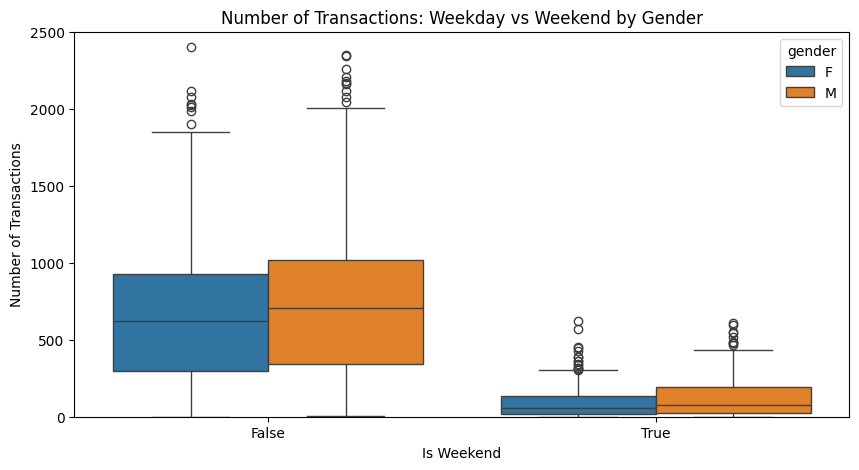

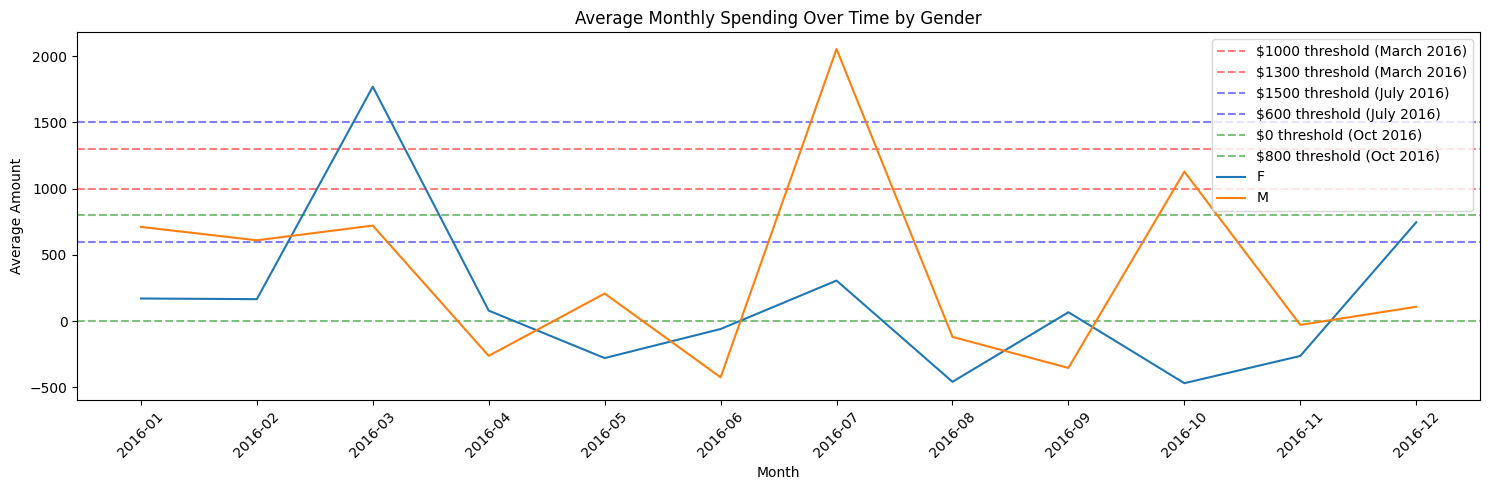

Category analysis:


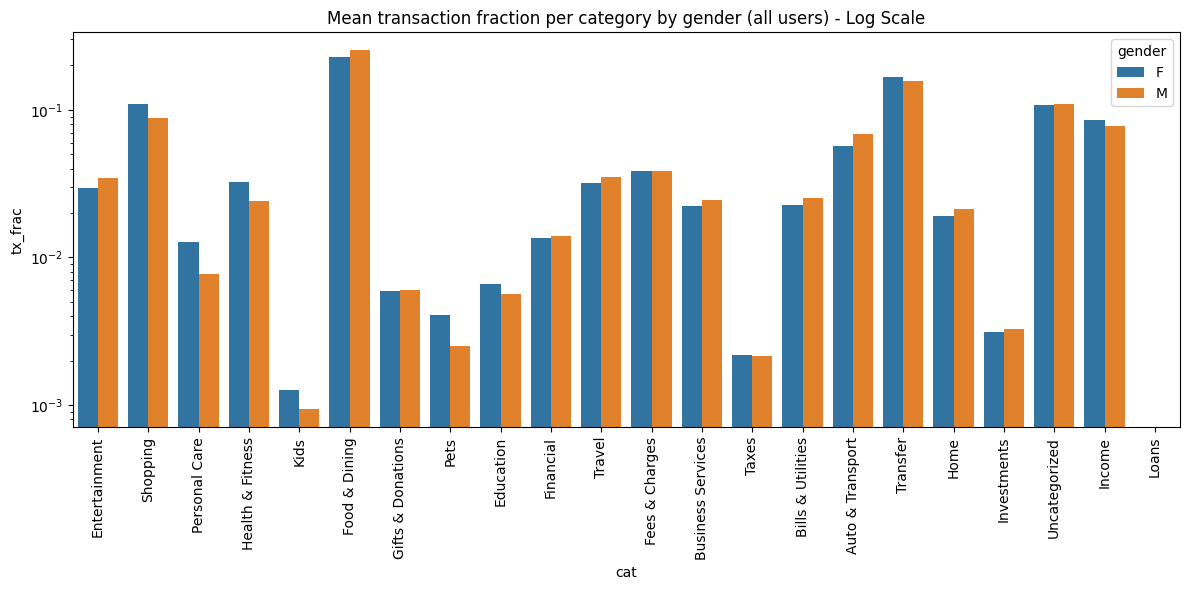

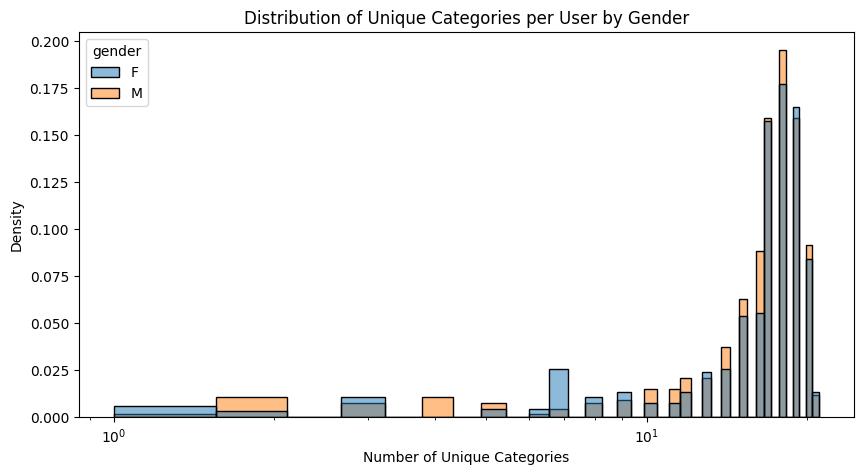

Merchant analysis:


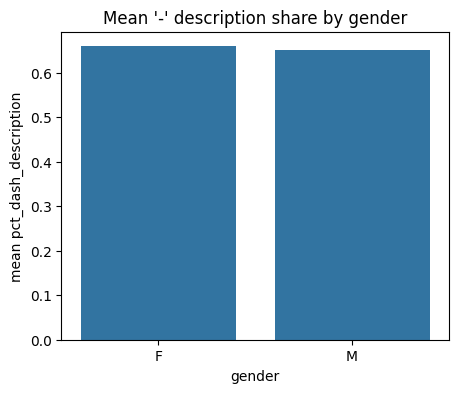

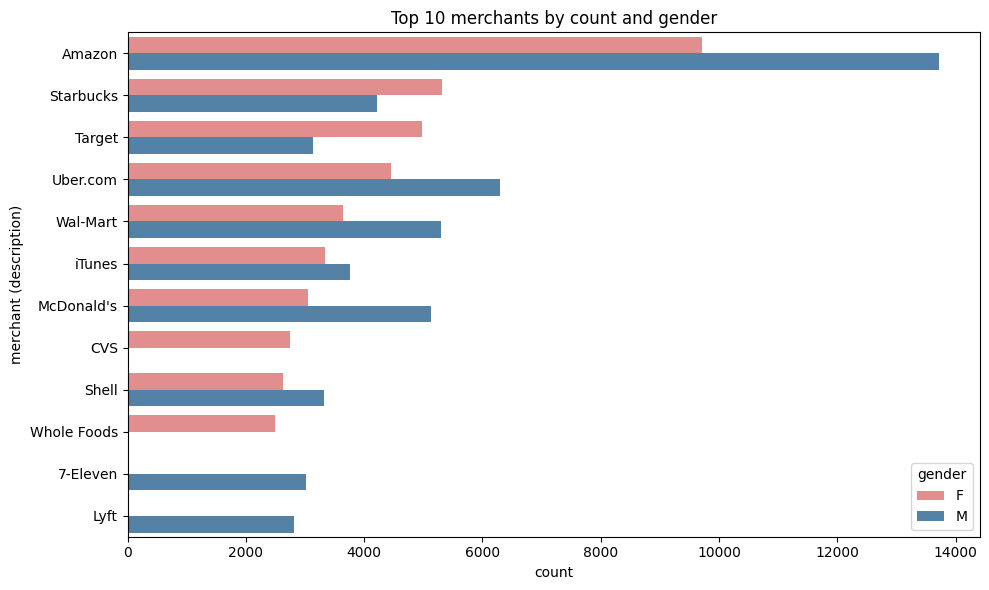

Correlation matrices:


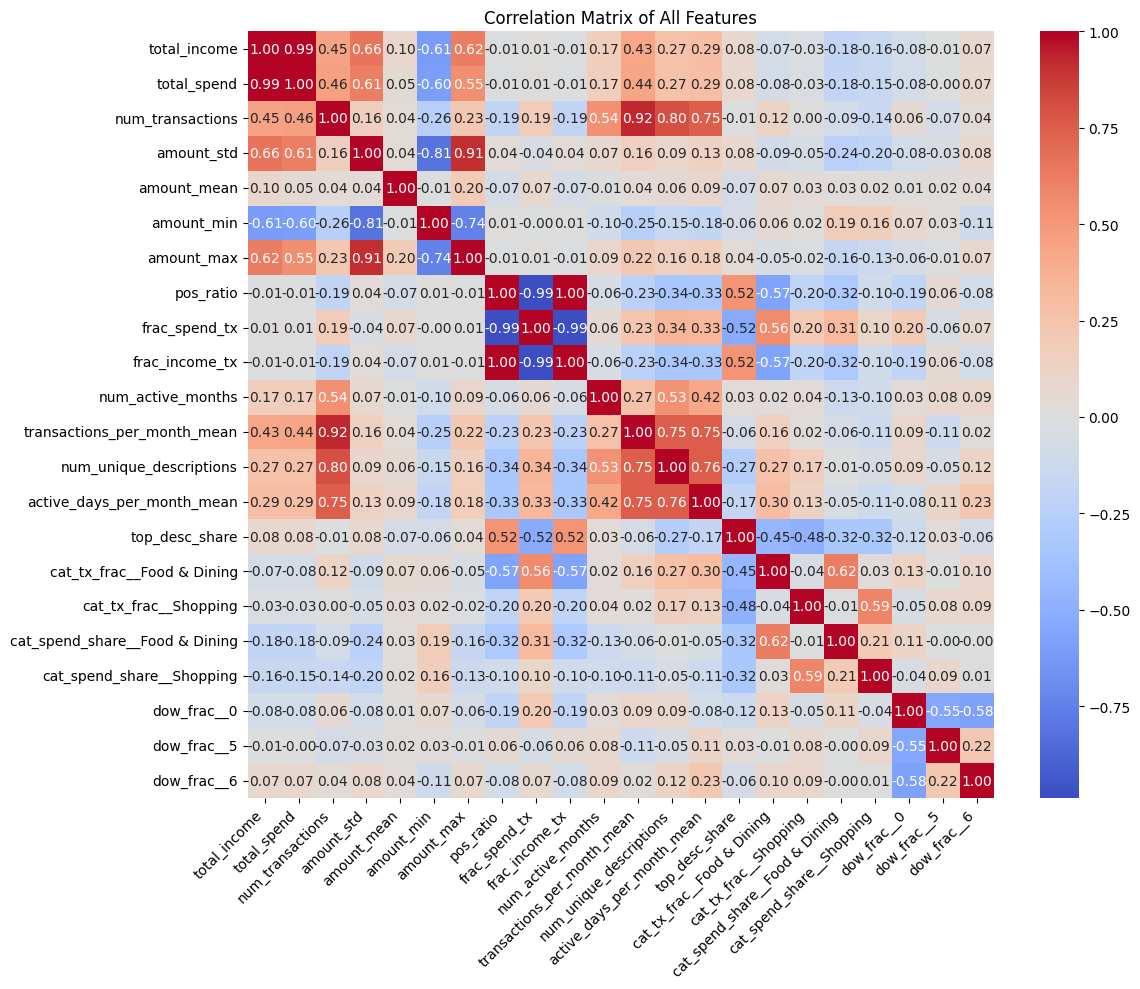

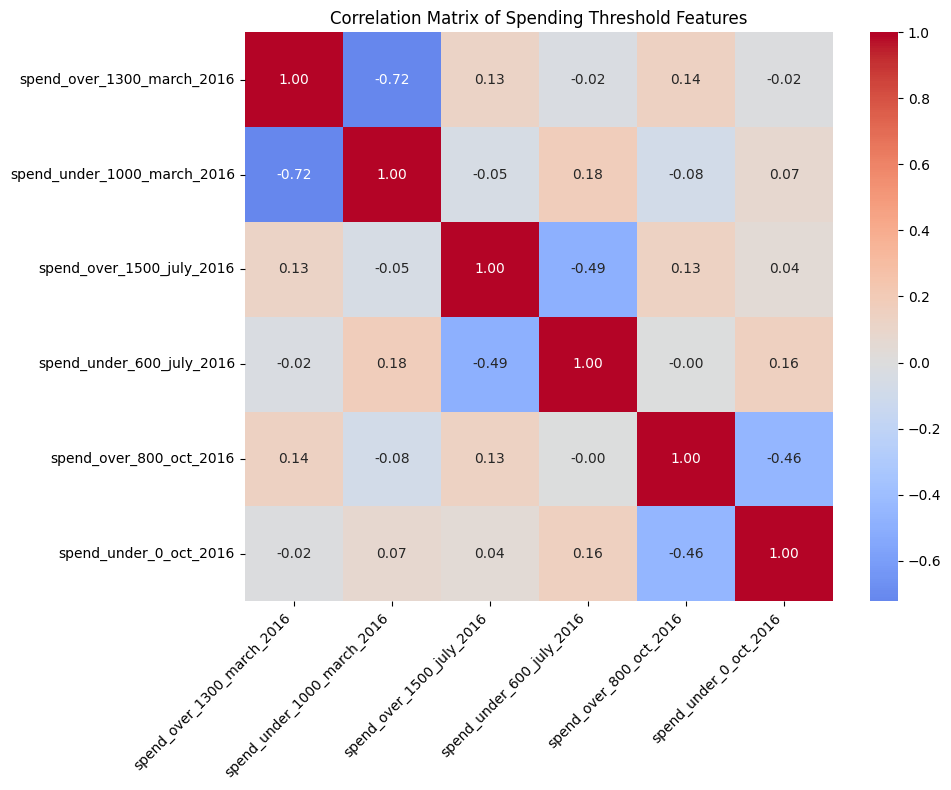

In [10]:
reload(utils)
utils.visualize(_df)

## Feature Groups and Aggregation Methods:

    1. Basic Transaction Counts:
        - num_unique_descriptions: Count of unique merchant descriptions

    2. Merchant/Description Features:
        - top_desc_share: Fraction of transactions with most frequent description
        - Binary indicators (1.0 if user has ever transacted with merchant, 0.0 otherwise):
        - has_{merchant}: One feature per top 10 merchant (TARGET, AMAZON, etc.)

    3. Amount-based Features:
        - amount_mean: Mean transaction amount
        - amount_min: Minimum transaction amount
        - amount_max: Maximum transaction amount
        - total_income: Sum of all positive amounts
        - frac_spend_tx: Fraction of negative amount transactions

    4. Category Distribution Features:
        For each main category, two features are computed:
        - cat_tx_frac__{category}: Fraction of transactions in category
        - cat_spend_share__{category}: Share of total spending in category
                                     (only negative amounts considered)

    5. Temporal Features:
        - transactions_per_month_mean: Average number of transactions per month
        - num_active_months: Total number of months with any activity
        - dow_frac__{0-6}: Fraction of transactions on each day of week
        - active_days_per_month_mean: Average number of unique days with activity per month
        - spend_over_1300_march_2016: Binary indicator if March 2016 spending > $1300
        - spend_under_1000_march_2016: Binary indicator if March 2016 spending < $1000
        - spend_over_1500_july_2016: Binary indicator if July 2016 spending > $1500  
        - spend_over_800_oct_2016: Binary indicator if October 2016 spending > $800
        - spend_under_600_july_2016: Binary indicator if July 2016 spending < $600
        - spend_under_0_oct_2016: Binary indicator if October 2016 spending < $0 (net income)



- Splits: stratified by gender at the user level (e.g., 80/10/10 train/val/test).

In [11]:
# === Stratified user-level splits ===
labels_all = build_label_frame(_df)
print("Users total:", len(labels_all))
print(labels_all['gender'].value_counts(normalize=True))

# Encode target for stratification
labels_all['_y'] = labels_all['gender'].map({'F':0, 'M':1}).astype(int)

# Train/Temp split (e.g., 80/20)
users_train, users_temp, y_train_tmp, y_temp = train_test_split(
    labels_all['user_id'], labels_all['_y'], test_size=0.2, random_state=RANDOM_STATE, stratify=labels_all['_y']
)
# Val/Test split from temp (split 20% into 10/10 of total)
users_val, users_test, y_val_tmp, y_test = train_test_split(
    users_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print("Train/Val/Test sizes (users):", len(users_train), len(users_val), len(users_test))

# Slice transactions per split
train_tx = _df[_df['user_id'].isin(set(users_train))].copy()
val_tx   = _df[_df['user_id'].isin(set(users_val))].copy()
test_tx  = _df[_df['user_id'].isin(set(users_test))].copy()

# Build features per split (leakage-safe)
X_train = build_user_features(train_tx)
X_val   = build_user_features(val_tx)
X_test  = build_user_features(test_tx)

y_train = labels_all.set_index('user_id').loc[X_train['user_id'], 'gender'].map({'F':0,'M':1}).values
y_val   = labels_all.set_index('user_id').loc[X_val['user_id'], 'gender'].map({'F':0,'M':1}).values
y_test  = labels_all.set_index('user_id').loc[X_test['user_id'], 'gender'].map({'F':0,'M':1}).values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

Users total: 1200
gender
M    0.520833
F    0.479167
Name: proportion, dtype: float64
Train/Val/Test sizes (users): 960 120 120
X_train shape: (960, 80)
X_val shape: (120, 80)
X_test shape: (120, 80)


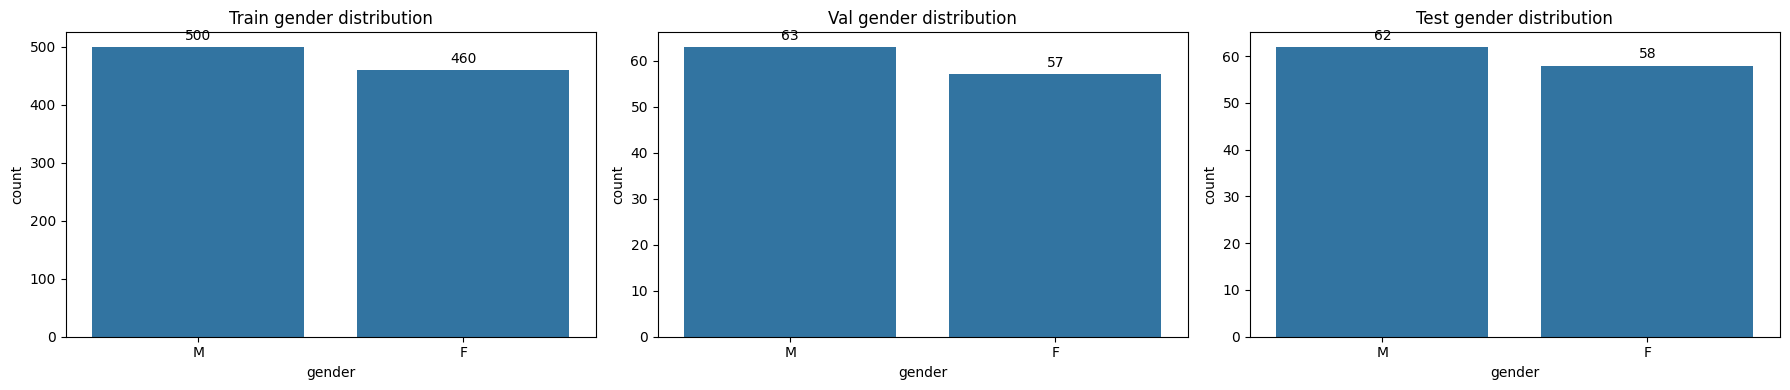

In [12]:
# === Visualization: gender distribution and transactions per user in train ===
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Gender distribution per split
for i, (name, users) in enumerate([('Train', users_train), ('Val', users_val), ('Test', users_test)]):
    gdf = labels_all[labels_all['user_id'].isin(set(users))]
    ax = sns.countplot(data=gdf, x='gender', ax=axes[i])
    axes[i].set_title(f'{name} gender distribution')
    for p in ax.patches:
        axes[i].annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                         ha='center', va='bottom', xytext=(0,3), textcoords='offset points')
plt.tight_layout()
plt.show()


In [13]:
# === Prepare model matrices and scaling where needed ===
# Drop identifier column
feature_cols = [c for c in X_train.columns if c != 'user_id']

Xtr = X_train[feature_cols].values
Xva = X_val[feature_cols].values
Xte = X_test[feature_cols].values

# Standardization for LR only
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr)
Xva_scaled = scaler.transform(Xva)
Xte_scaled = scaler.transform(Xte)

print(len(feature_cols), "features")

X_train_show = X_train.copy()
X_train_show.drop(columns=['user_id'], inplace=True)
X_train_show.head()


79 features


,num_unique_descriptions,top_desc_share,has_target,has_amazon,has_starbucks,has_uber.com,has_wal-mart,has_itunes,has_mcdonald's,has_cvs,has_shell,has_whole_foods,has_7-eleven,has_lyft,amount_mean,amount_min,amount_max,total_income,frac_spend_tx,cat_tx_frac__Entertainment,cat_tx_frac__Shopping,cat_tx_frac__Personal Care,cat_tx_frac__Health & Fitness,cat_tx_frac__Kids,cat_tx_frac__Food & Dining,cat_tx_frac__Gifts & Donations,cat_tx_frac__Pets,cat_tx_frac__Education,cat_tx_frac__Financial,cat_tx_frac__Travel,cat_tx_frac__Fees & Charges,cat_tx_frac__Business Services,cat_tx_frac__Taxes,cat_tx_frac__Bills & Utilities,cat_tx_frac__Auto & Transport,cat_tx_frac__Transfer,cat_tx_frac__Home,cat_tx_frac__Investments,cat_tx_frac__Uncategorized,cat_tx_frac__Income,cat_tx_frac__Loans,cat_spend_share__Entertainment,cat_spend_share__Shopping,cat_spend_share__Personal Care,cat_spend_share__Health & Fitness,cat_spend_share__Kids,cat_spend_share__Food & Dining,cat_spend_share__Gifts & Donations,cat_spend_share__Pets,cat_spend_share__Education,cat_spend_share__Financial,cat_spend_share__Travel,cat_spend_share__Fees & Charges,cat_spend_share__Business Services,cat_spend_share__Taxes,cat_spend_share__Bills & Utilities,cat_spend_share__Auto & Transport,cat_spend_share__Transfer,cat_spend_share__Home,cat_spend_share__Investments,cat_spend_share__Uncategorized,cat_spend_share__Income,cat_spend_share__Loans,spend_over_1300_march_2016,spend_under_1000_march_2016,spend_over_1500_july_2016,spend_over_800_oct_2016,spend_under_600_july_2016,spend_under_0_oct_2016,transactions_per_month_mean,dow_frac__0,dow_frac__1,dow_frac__2,dow_frac__3,dow_frac__4,dow_frac__5,dow_frac__6,num_active_months,active_days_per_month_mean
0,73,0.587025,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,6.476187,-2280.00,5788.92,47212.52,0.841772,0.033228,0.166139,0.022152,0.020570,0.000000,0.191456,0.012658,0.020570,0.000000,0.004747,0.026899,0.009494,0.050633,0.000000,0.001582,0.102848,0.132911,0.028481,0.0,0.093354,0.082278,0.0,0.016303,0.116767,0.020192,0.012157,0.000000,0.047773,0.007493,0.034310,0.000000,0.067410,0.006559,0.000233,0.016234,0.000000,0.000121,0.026547,0.427125,0.057512,0.0,0.143263,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,52.666667,0.403481,0.150316,0.145570,0.161392,0.139241,0.000000,0.000000,12,15.250000
1,95,0.638912,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-20.743908,-14800.00,7140.00,204312.05,0.763397,0.027205,0.061006,0.001649,0.032976,0.002473,0.215993,0.000824,0.000000,0.000824,0.002473,0.032152,0.016488,0.008244,0.003298,0.043693,0.078318,0.340478,0.019786,0.0,0.055235,0.056884,0.0,0.001255,0.019890,0.000335,0.027247,0.001219,0.031482,0.000074,0.000000,0.000130,0.002956,0.047417,0.000769,0.006939,0.002241,0.013834,0.019159,0.714691,0.025986,0.0,0.084375,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,101.083333,0.442704,0.152514,0.098104,0.075845,0.145095,0.043693,0.042045,12,24.500000
2,28,0.560484,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,18.984698,-4600.00,9730.00,52104.51,0.895161,0.052419,0.062500,0.002016,0.022177,0.000000,0.104839,0.000000,0.000000,0.002016,0.012097,0.272177,0.010081,0.008065,0.004032,0.008065,0.024194,0.139113,0.014113,0.0,0.227823,0.034274,0.0,0.013136,0.033202,0.000226,0.016923,0.000000,0.040963,0.000000,0.000000,0.004397,0.010376,0.028108,0.002325,0.002071,0.006703,0.003752,0.036128,0.525668,0.029567,0.0,0.246455,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,99.200000,0.252016,0.141129,0.137097,0.100806,0.161290,0.004032,0.203629,5,21.200000
3,105,0.702036,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-17.273695,-13000.00,15362.32,153760.61,0.875386,0.045034,0.119062,0.011104,0.040716,0.000000,0.223319,0.003701,0.009254,0.005552,0.002468,0.061073,0.011721,0.032079,0.001851,0.025293,0.038865,0.161012,0.023442,0.0,0.157310,0.027144,0.0,0.010830,0.060345,0.005355,0.013628,0.000000,0.058694,0.000906,0.002123,0.039215,0.001920,0.014316,0.008299,0.007478,0.012418,0.088136,0.005990,0.429833,0.032097,0.0,0.208417,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,135.083333,


- Normalization:
  - Tree models do not require scaling.
  - Logistic Regression will use `StandardScaler` fitted on train only.
- Models: Decision Tree, Random Forest, Logistic Regression. We will compare accuracy, precision, recall, F1 and pick the best based on F1 (and overall balance).


In [20]:
# === Train models: Decision Tree, Random Forest, Logistic Regression ===
import xgboost as xgb

models = {}

# Decision Tree (simple, controlled depth)
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
dt.fit(Xtr, y_train)
models['DecisionTree'] = dt

# Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
)
rf.fit(Xtr, y_train)
models['RandomForest'] = rf

# XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=RANDOM_STATE
)
xgb_clf.fit(Xtr, y_train)
models['XGBoost'] = xgb_clf

# Logistic Regression (scaled)
lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    max_iter=200,
    solver='lbfgs',
)
lr.fit(Xtr_scaled, y_train)
models['LogisticRegression'] = lr

print("Trained:", list(models.keys()))


Trained: ['DecisionTree', 'RandomForest', 'XGBoost', 'LogisticRegression']


In [21]:
# === Evaluate on validation and test ===
results = []
for name, model in models.items():
    scaled = True if name == 'LogisticRegression' else False
    metrics, yhat_va, yhat_tr = eval_model(name=name, model=model, Xtr=Xtr, Xva=Xva, Xtr_scaled=Xtr_scaled, Xva_scaled=Xva_scaled, y_train=y_train, y_val=y_val, scaled=scaled)
    results.append(metrics)

res_df = pd.DataFrame(results).sort_values('val_f1', ascending=False)
print(res_df)


                model  train_accuracy  train_precision  train_recall  \
1        RandomForest        0.987500         0.988000         0.988   
2             XGBoost        1.000000         1.000000         1.000   
3  LogisticRegression        0.744792         0.745665         0.774   
0        DecisionTree        0.883333         0.909283         0.862   

   train_f1  val_accuracy  val_precision  val_recall    val_f1  
1  0.988000      0.616667       0.616438    0.714286  0.661765  
2  1.000000      0.616667       0.619718    0.698413  0.656716  
3  0.759568      0.625000       0.636364    0.666667  0.651163  
0  0.885010      0.525000       0.557692    0.460317  0.504348  


          model  test_accuracy  test_precision  test_recall   test_f1
0  RandomForest       0.633333        0.632353     0.693548  0.661538


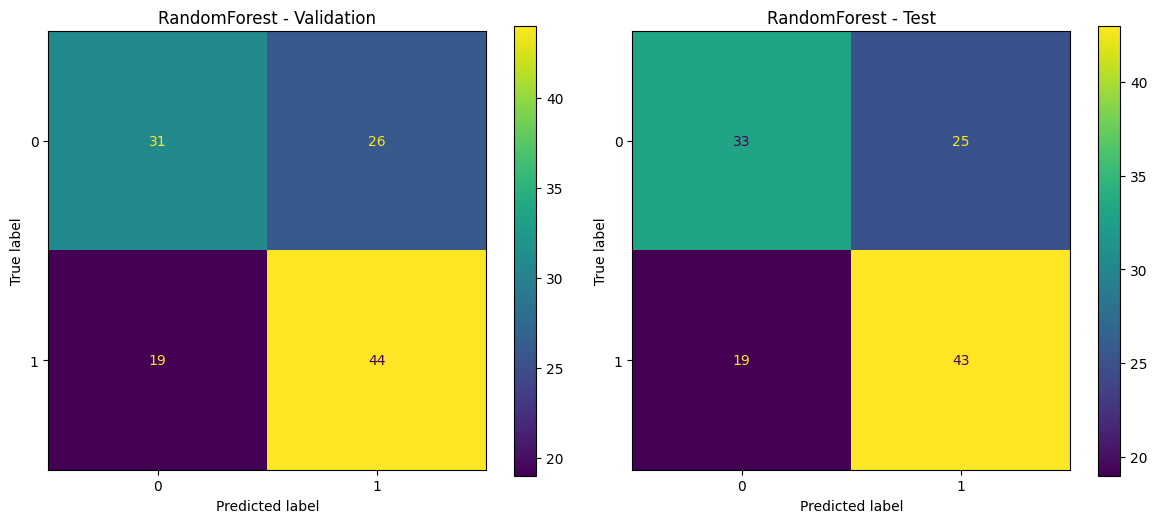

In [16]:
# === Visualizations: Confusion matrices and metrics for the test set ===

best_name = res_df.iloc[0]['model']
best_model = models[best_name]
scaled = best_name in ('LogisticRegression', 'PretrainedNN')
test_result = []

metrics, yhat_te= test_results(best_name, best_model, Xte, Xte_scaled, y_test, scaled=scaled)

test_result.append(metrics)
test_result = pd.DataFrame(test_result)
print(test_result)

best_model = models[best_name]
use_scaled = best_name in ('LogisticRegression', 'PretrainedNN')

Xva_i = Xva_scaled if use_scaled else Xva
Xte_i = Xte_scaled if use_scaled else Xte

fig, axes = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_val, best_model.predict(Xva_i), ax=axes[0])
axes[0].set_title(f'{best_name} - Validation')
ConfusionMatrixDisplay.from_predictions(y_test, best_model.predict(Xte_i), ax=axes[1])
axes[1].set_title(f'{best_name} - Test')
plt.tight_layout()
plt.show()


### I could continue to fine-tune the parameters of the models, but since this is a time-limited assignment, I will just say that I would simply do a hyperparameter sweep on the possible options (I would try to do this randomly), and check the results on a validation set and decide based on that.